In [18]:
from datasets import load_dataset
from collections import Counter
from matplotlib import pyplot as plt

In [2]:
squad_data = (
    load_dataset("squad", split="train+validation")
    .select_columns(["context", "question"])
    .rename_columns({"context": "source", "question": "target"})
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [3]:
dataset_count = squad_data.shape[0]
dataset_count

(98169, 2)

In [16]:
def add_unigram(example):
    example["unigram"] = " ".join(example["target"].split(" ")[:1])
    return example

squad_leading_unigram = squad_data.map(add_unigram)

unigram_leading_word_counts = Counter(squad_leading_unigram["unigram"])

most_common_bigram_leading_words = unigram_leading_word_counts.most_common(10)
print(f"{'Unigram': <20}{'Percentage': <10}")
print("-" * 30)
for word, count in most_common_bigram_leading_words:
    p = count / dataset_count * 100
    print(f"{word: <20}{p:.2f}%")


Unigram             Percentage
------------------------------
What                42.79%
How                 9.33%
Who                 9.30%
When                6.22%
In                  4.83%
Which               4.68%
Where               3.76%
The                 2.57%
Why                 1.37%
On                  0.64%


## Most Frequent Leading Bigram

In [17]:
from collections import Counter

def add_bigram(example):
    example["bigram"] = " ".join(example["target"].split(" ")[:2])
    return example

squad_leading_bigram = squad_data.map(add_bigram)

bigram_leading_word_counts = Counter(squad_leading_bigram["bigram"])

most_common_bigram_leading_words = bigram_leading_word_counts.most_common(10)
print(f"{'Bigram': <20}{'Percentage': <10}")
print("-" * 30)
for word, count in most_common_bigram_leading_words:
    p = count/dataset_count*100
    print(f"{word: <20}{p:.2f}%")

Bigram              Percentage
------------------------------
What is             8.49%
What was            5.27%
How many            4.85%
When did            3.12%
In what             2.85%
What did            2.77%
When was            2.11%
Who was             2.07%
What are            1.67%
What does           1.66%


## Distribution of Target and Source Length

In [19]:
from transformers import T5Tokenizer, BartTokenizer


bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [20]:
def add_target_tokens(example):
    example["bart"] = len(bart_tokenizer.tokenize(example["target"]))
    example["t5"] = len(t5_tokenizer.tokenize(example["target"]))
    return example

question_length = squad_data.map(add_target_tokens)
question_length[0]

Map:   0%|          | 0/98169 [00:00<?, ? examples/s]

{'source': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'target': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'bart': 17,
 't5': 18}

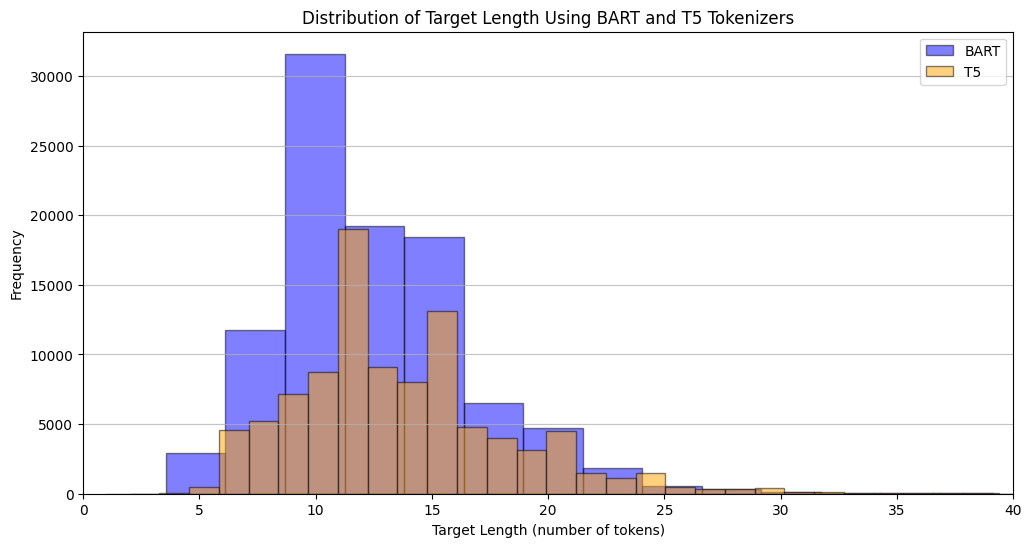

In [31]:
plt.figure(figsize=(12, 6))
plt.hist(question_length["bart"], bins=10000, alpha=0.5, label='BART', color='blue', edgecolor='black')
plt.hist(question_length["t5"], bins=50, alpha=0.5, label='T5', color='orange', edgecolor='black')
plt.xlim(0, 40)
plt.title('Distribution of Target Length Using BART and T5 Tokenizers')
plt.xlabel('Target Length (number of tokens)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

In [32]:
def add_source_tokens(example):
    example["bart"] = len(bart_tokenizer.tokenize(example["source"]))
    example["t5"] = len(t5_tokenizer.tokenize(example["source"]))
    return example

source_length = squad_data.map(add_source_tokens)
source_length[0]

Map:   0%|          | 0/98169 [00:00<?, ? examples/s]

{'source': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'target': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'bart': 160,
 't5': 179}

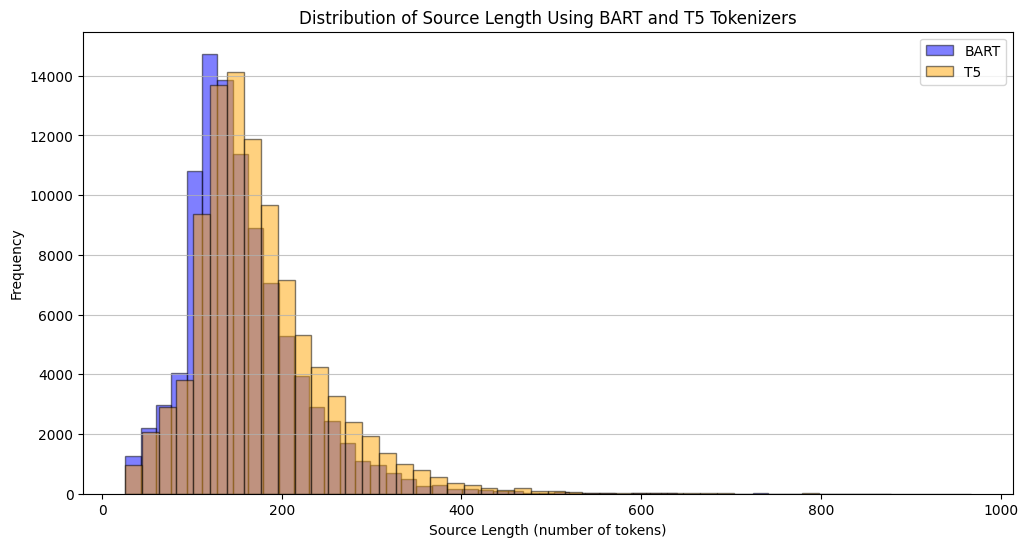

In [33]:
plt.figure(figsize=(12, 6))
plt.hist(source_length["bart"], bins=50, alpha=0.5, label='BART', color='blue', edgecolor='black')
plt.hist(source_length["t5"], bins=50, alpha=0.5, label='T5', color='orange', edgecolor='black')
plt.title('Distribution of Source Length Using BART and T5 Tokenizers')
plt.xlabel('Source Length (number of tokens)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()